# Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc('figure', figsize=(10,6))

In [3]:
import os
folder = r"./datasets\titanic"
file='train.csv'
path = os.path.join(folder, file)

In [4]:
titanic = pd.read_csv(path)
titanic.shape

(891, 12)

In [5]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


    Age has null-values
    It's best to drop the cabin attribute, too many missing values.
    Ticket, ID and Embarked attributes serve no purpose, drop them too.
    Combine SibSp and Parch to form Relatives attribute.

# Visualisation

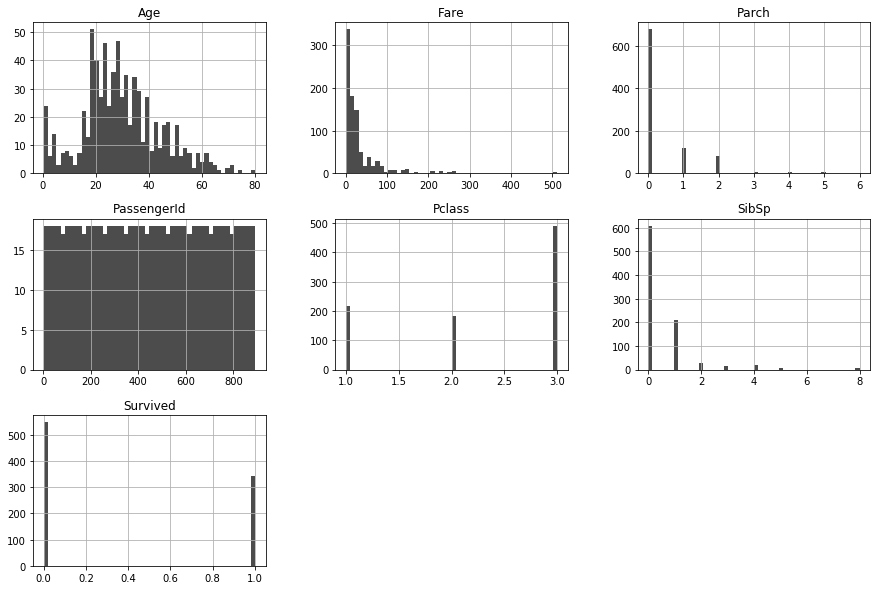

In [7]:
titanic.hist(bins=50, figsize=(15,10), color='k', alpha=0.7)
plt.show()

In [8]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Age 

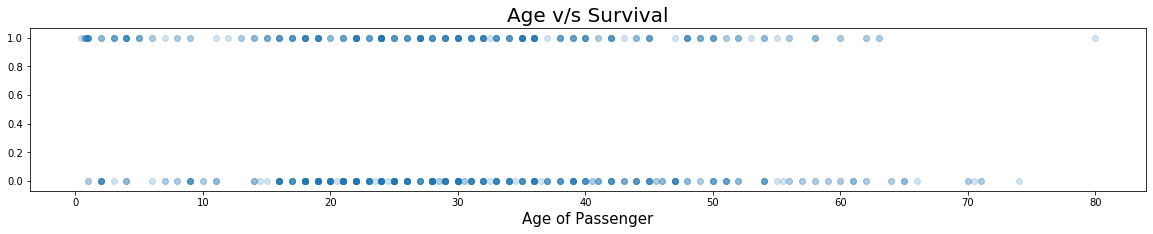

In [9]:
plt.figure(figsize=(20,3))
plt.scatter(titanic.Age, titanic.Survived, alpha=0.2)
plt.title('Age v/s Survival', fontsize=20)
plt.xlabel('Age of Passenger', fontsize=15) # 1=survived
plt.show()

Age doesn't seem to be much of a deciding factor.

### Fare

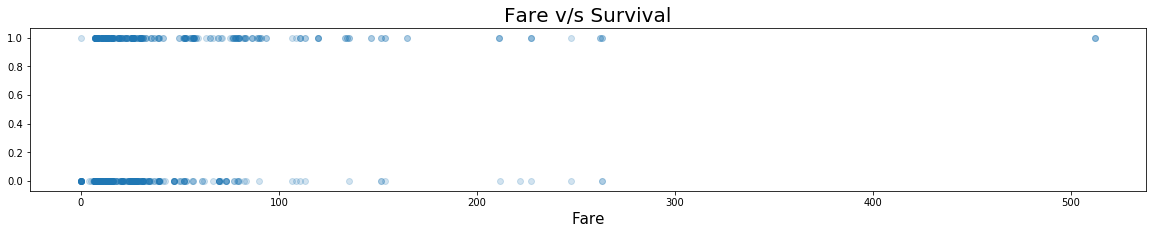

In [10]:
plt.figure(figsize=(20,3))
plt.scatter(titanic.Fare, titanic.Survived, alpha=0.2)
plt.title('Fare v/s Survival', fontsize=20)
plt.xlabel('Fare', fontsize=15) # 1=survived
plt.show()

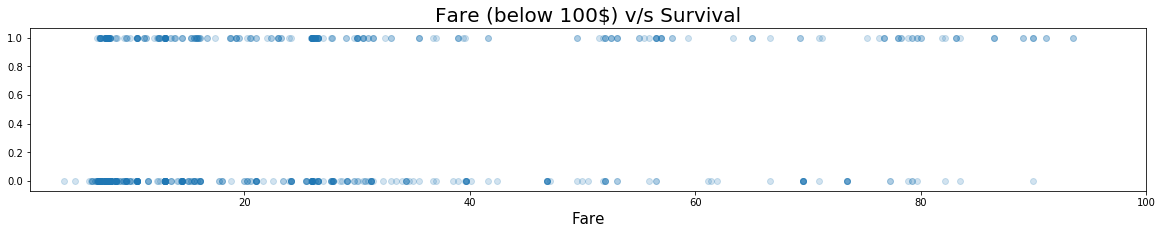

In [11]:
plt.figure(figsize=(20,3))
plt.scatter(titanic.Fare, titanic.Survived, alpha=0.2)
plt.title('Fare (below 100$) v/s Survival', fontsize=20)
plt.xlabel('Fare', fontsize=15) # 1=survived
plt.xlim(1,100)
plt.show()

Fare doesn't seem to determine survival

### Gender

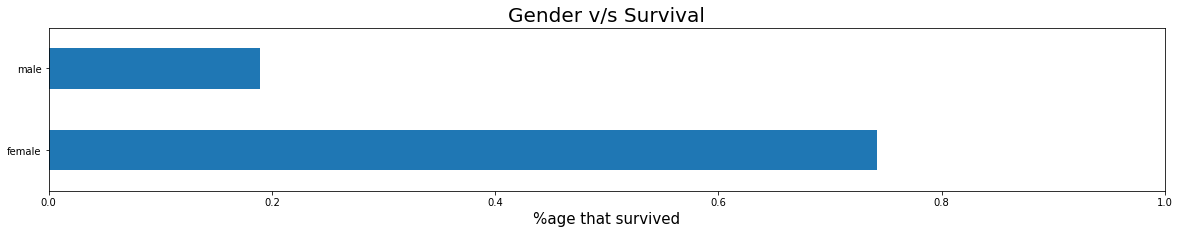

In [12]:
plt.figure(figsize=(20,3))
(titanic.Sex[titanic.Survived==1].value_counts()/titanic.Sex.value_counts()).plot.barh(stacked=True)
plt.title('Gender v/s Survival', fontsize=20)
plt.xlabel('%age that survived', fontsize=15)
plt.xlim(0,1)
plt.show()

A lot more women survived. So being a woman increases chances of survival a lot.

### Pclass

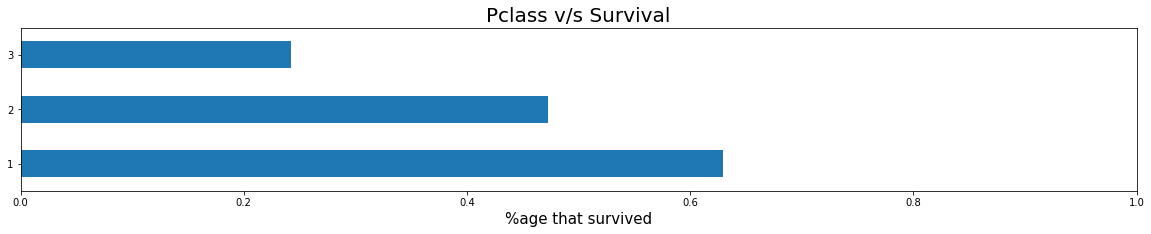

In [13]:
plt.figure(figsize=(20,3))
(titanic.Pclass[titanic.Survived==1].value_counts()/titanic.Pclass.value_counts()).plot.barh(stacked=True)
plt.title('Pclass v/s Survival', fontsize=20)
plt.xlabel('%age that survived', fontsize=15)
plt.xlim(0,1)
plt.show()

Class 1 Passengers have a lower probabilty to survive

### Relatives

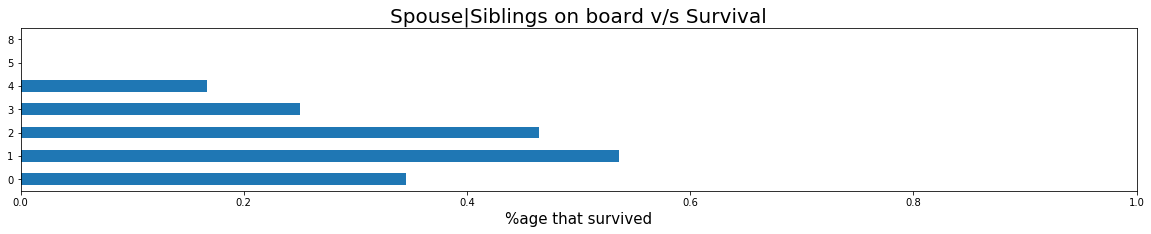

In [14]:
plt.figure(figsize=(20,3))
(titanic.SibSp[titanic.Survived==1].value_counts()/titanic.SibSp.value_counts()).plot.barh(stacked=True)
plt.title('Spouse|Siblings on board v/s Survival', fontsize=20)
plt.xlabel('%age that survived', fontsize=15)
plt.xlim(0,1)
plt.show()

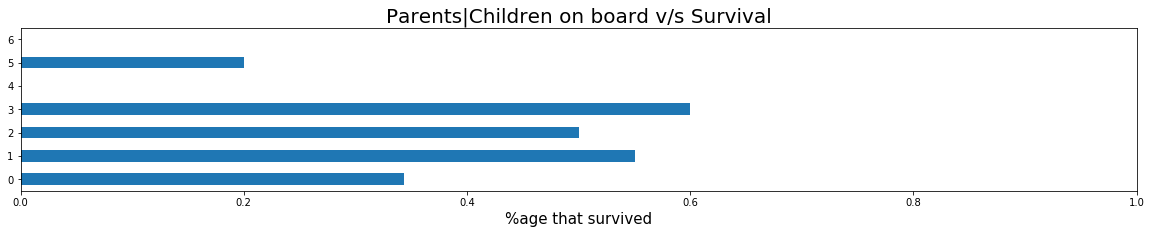

In [15]:
plt.figure(figsize=(20,3))
(titanic.Parch[titanic.Survived==1].value_counts()/titanic.Parch.value_counts()).plot.barh(stacked=True)
plt.title('Parents|Children on board v/s Survival', fontsize=20)
plt.xlabel('%age that survived', fontsize=15)
plt.xlim(0,1)
plt.show()

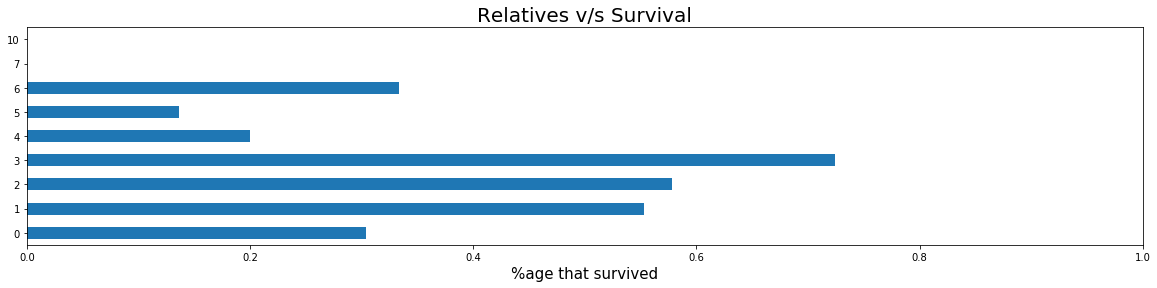

In [16]:
relatives=pd.Series(titanic.Parch + titanic.SibSp)
rel_survival_ratio = relatives[titanic.Survived==1].value_counts()/relatives.value_counts()
rel_survival_ratio = rel_survival_ratio.fillna(0)

plt.figure(figsize=(20,4))
rel_survival_ratio.plot.barh()
plt.title('Relatives v/s Survival', fontsize=20)
plt.xlabel('%age that survived', fontsize=15)
plt.xlim(0,1)
plt.show()

# Wrangling

In [17]:
def relatives(df):
    df_1 = df.copy()
    df_1['Relatives'] = df_1['SibSp'].fillna(df_1['SibSp'].median()) + df_1['Parch'].fillna(df_1['Parch'].median())
    df1 = df_1.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    return df_1

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Make bins for Pclass, age and Fare

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_attribs = ['Pclass', 'Relatives'] #note that we are dropping the Survived column as it is the target attrib
num_pipeline = Pipeline(steps=[
    ('num_attribs', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='mean')),
    
])

The `SimpleImputer` does not work on string values. So we need to create our own Imputer.

In [20]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [21]:
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['Sex']
cat_pipeline = Pipeline(steps=[
    ('cat_attribs', DataFrameSelector(cat_attribs)),
    ('imputer', MostFrequentImputer()),
    ('encoder', OneHotEncoder(sparse=False)) #returns an np array this way.
])

In [22]:
from sklearn.pipeline import FeatureUnion
total_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [23]:
X_train = total_pipeline.fit_transform(relatives(titanic))
y_train = titanic.Survived

In [24]:
X_train[0], y_train[0]

(array([3., 1., 0., 1.]), 0)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [26]:
X_scaled[0], y_train[0]

(array([ 0.82737724,  0.05915988, -0.73769513,  0.73769513]), 0)

# Model Selection

In [27]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

### LinearSVC

In [28]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(loss='hinge')
lin_svc.fit(X_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [29]:
confusion_matrix(y_train, lin_svc.predict(X_scaled))

array([[468,  81],
       [109, 233]], dtype=int64)

In [30]:
f1_score(y_train, lin_svc.predict(X_scaled))

0.7103658536585367

In [31]:
scores = cross_val_score(lin_svc, X_scaled, y_train, cv=5, scoring='f1')
print(scores, '\n')
print('Mean score: ', scores.mean())
print('STD: ', scores.std())

[0.74452555 0.74074074 0.71212121 0.64516129 0.703125  ] 

Mean score:  0.7091347581259578
STD:  0.03574657127243649


### SVC

In [32]:
from sklearn.svm import SVC
svc =SVC(gamma='auto')
svc.fit(X_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
confusion_matrix(y_train, svc.predict(X_scaled))

array([[493,  56],
       [117, 225]], dtype=int64)

In [34]:
scores = cross_val_score(svc, X_scaled, y_train, cv=5, scoring='f1')
print(scores, '\n')
print('Mean score: ', scores.mean())
print('STD: ', scores.std())

[0.74418605 0.74242424 0.734375   0.67826087 0.73170732] 

Mean score:  0.7261906951148517
STD:  0.024421485915652765


In [35]:
from sklearn.model_selection import GridSearchCV
svc= SVC(kernel='rbf')
param_grid = [
    {'C':[0.01,0.1,1,2,10], 'gamma':[0.01, 0.1, 1, 10]}
]
grid_search = GridSearchCV(svc,param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 2, 10],
                          'gamma': [0.01, 0.1, 1, 10]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [36]:
grid_search.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1}

In [38]:
confusion_matrix(y_train, grid_search.best_estimator_.predict(X_scaled))

array([[492,  57],
       [112, 230]], dtype=int64)

In [39]:
f1_score(y_train, grid_search.best_estimator_.predict(X_scaled))

0.7313195548489666

In [40]:
from sklearn.metrics import precision_score
precision_score(y_train, grid_search.best_estimator_.predict(X_scaled))

0.8013937282229965

from sklearn.model_selection import GridSearchCV
svc= SVC(kernel='poly')
param_grid = [
    {'C':[0.01,0.1,1,10], 'gamma':[0.01, 0.1, 1, 10], 'degree':[2,3,4,5,6]}
]
grid_search = GridSearchCV(svc,param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_scaled, y_train)

### SVC kernel = poly

In [41]:
svc_poly = SVC(kernel='poly', degree=7)
svc_poly.fit(X_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=7, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [42]:
confusion_matrix(y_train, svc_poly.predict(X_scaled))

array([[492,  57],
       [109, 233]], dtype=int64)

In [43]:
f1_score(y_train, svc_poly.predict(X_scaled))

0.7373417721518989

In [44]:
precision_score(y_train, svc_poly.predict(X_scaled))

0.803448275862069

svc= SVC(kernel='poly', degree=7)
param_grid = [
    {'C':[0.01,0.1,1,2,10], 'gamma':[0.01, 0.1, 1, 10]}
]
grid_search = GridSearchCV(svc, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_scaled, y_train)

# Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100,  min_samples_leaf=5, max_depth=5)

In [46]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
confusion_matrix(y_train, forest_clf.predict(X_scaled))

array([[465,  84],
       [109, 233]], dtype=int64)

In [48]:
f1_score(y_train, forest_clf.predict(X_scaled))

0.7071320182094082

In [49]:
from sklearn.metrics import precision_score
precision_score(y_train, forest_clf.predict(X_scaled))

0.7350157728706624

### RandomForest

In [50]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier()
param_grid = [
    {'n_estimators':[5,7,10],  'min_samples_leaf':[3,5,10], 'max_depth':[3,4,5], 'warm_start':[True, False]}
]
grid_search = GridSearchCV(forest, param_grid, cv=10, scoring='f1')
grid_search.fit(X_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [51]:
grid_search.best_params_

{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 10, 'warm_start': True}

    {'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 7, 'warm_start': True}

In [52]:
confusion_matrix(y_train, grid_search.best_estimator_.predict(X_scaled))

array([[492,  57],
       [112, 230]], dtype=int64)

    Confusion Matrix:
    array([[492,  57],
       [109, 233]], dtype=int64)

In [53]:
precision_score(y_train, grid_search.best_estimator_.predict(X_scaled))

0.8013937282229965

    0.803448275862069

In [54]:
grid_search.best_estimator_.predict_proba(X_scaled[:10])

array([[0.8158967 , 0.1841033 ],
       [0.06762145, 0.93237855],
       [0.39546939, 0.60453061],
       [0.06762145, 0.93237855],
       [0.86615134, 0.13384866],
       [0.86615134, 0.13384866],
       [0.77131787, 0.22868213],
       [0.93163237, 0.06836763],
       [0.39144641, 0.60855359],
       [0.07727906, 0.92272094]])

In [55]:
from sklearn.metrics import roc_curve

In [56]:
def plot_ROC(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=15)

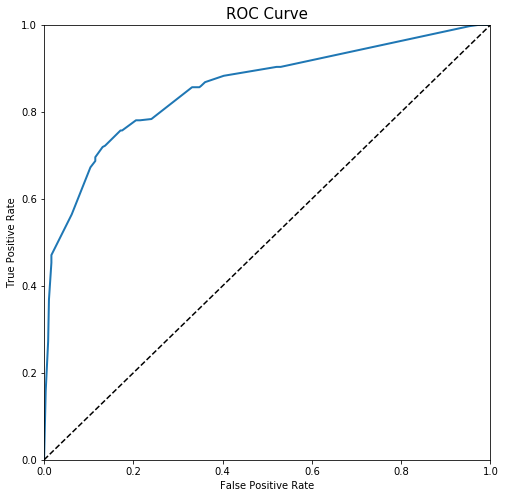

In [57]:
plt.figure(figsize=(8,8))
forest_proba = grid_search.best_estimator_.predict_proba(X_scaled)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, forest_proba[:,1])
plot_ROC(fpr_forest, tpr_forest, label='RandomForest')
plt.show()

In [58]:
forest_clf  = grid_search.best_estimator_
scores = cross_val_score(forest_clf, X_scaled, y_train, cv=10, scoring='accuracy')
print(scores, '\n')
print('Mean Accuracy: ', scores.mean())
print('STD: ', scores.std())

[0.8        0.82222222 0.78651685 0.84269663 0.83146067 0.78651685
 0.80898876 0.78651685 0.83146067 0.79545455] 

Mean Accuracy:  0.8091834071047554
STD:  0.02024814164989238


In [59]:
forest_clf  = grid_search.best_estimator_
scores = cross_val_score(forest_clf, X_scaled, y_train, cv=10, scoring='f1')
print(scores, '\n')
print('Mean f1: ', scores.mean())
print('STD: ', scores.std())

[0.73846154 0.75757576 0.68852459 0.8        0.7761194  0.68852459
 0.71186441 0.66666667 0.75409836 0.70967742] 

Mean f1:  0.7291512732807145
STD:  0.04077497316412292


## Summary

LinearSVC : f1(71%)<br>
SVC (rbf): f1(73%)<br>
SVC(poly): f1(74%)<br>
DecisionTree: f1(71%)<br>
RandomForest: f1(73%)

## Logistic Regression

In [111]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
lin_reg_df = pd.DataFrame(lin_reg.predict(X_scaled), columns=['Survived'])
lin_reg_df[lin_reg_df.Survived<=0.5]=0
lin_reg_df[lin_reg_df.Survived>0.5]=1

In [136]:
lin_reg_df.Survived.value_counts()

0.0    582
1.0    309
Name: Survived, dtype: int64

In [137]:
(lin_reg_df.Survived - y_train).value_counts()

 0.0    706
-1.0    109
 1.0     76
Name: Survived, dtype: int64

In [141]:
print('accuracy = ',706/891*100)

accuracy =  79.2368125701459


# Predictions

In [ ]:
folder = r"./datasets\titanic"
file='test.csv'
path = os.path.join(folder, file)

In [62]:
test = pd.read_csv(path)
test.shape

(418, 11)

In [63]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [64]:
X_test = total_pipeline.fit_transform(relatives(test))
X_test_scaled = scaler.fit_transform(X_test)

In [66]:
svc_poly.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 7,
 'gamma': 'auto_deprecated',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
predictions = svc_poly.predict(X_test_scaled)

In [69]:
final_df = pd.DataFrame({'PassengerID':test.PassengerId, 'Survived':predictions})
final_df.shape

(418, 2)

In [70]:
final_df.head(3)

,PassengerID,Survived
0,892,0
1,893,1
2,894,0


In [72]:
final_df.to_csv('titanic_submission.csv', index=False)

In [74]:
df = pd.read_csv('titanic_submission.csv')
df.head(3)

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
